In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
import seaborn as sns

In [11]:
class Layer:
    def __init__(self, input_dim, output_dim, activation='relu', use_dropout=False, dropout_rate=0.2):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation_name = activation
        self.use_dropout = use_dropout
        self.dropout_rate = dropout_rate
        
        scale = np.sqrt(2. / input_dim)
        self.W = np.random.randn(input_dim, output_dim) * scale
        self.b = np.zeros(output_dim)
        self.mask = None
        
    def activation(self, x):
        if self.activation_name == 'relu':
            return np.maximum(0, x)
        elif self.activation_name == 'sigmoid':
            return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
        elif self.activation_name == 'tanh':
            return np.tanh(x)
        elif self.activation_name == 'leaky_relu':
            return np.where(x > 0, x, 0.01 * x)
    
    def activation_derivative(self, x):
        if self.activation_name == 'relu':
            return np.where(x > 0, 1, 0)
        elif self.activation_name == 'sigmoid':
            s = self.activation(x)
            return s * (1 - s)
        elif self.activation_name == 'tanh':
            return 1 - np.tanh(x)**2
        elif self.activation_name == 'leaky_relu':
            return np.where(x > 0, 1, 0.01)
    
    def forward(self, input_data, training=True):
        self.input = input_data
        self.z = np.dot(input_data, self.W) + self.b
        self.output = self.activation(self.z)
        
        if self.use_dropout and training:
            self.mask = np.random.binomial(1, 1-self.dropout_rate, size=self.output.shape)
            self.output *= self.mask / (1-self.dropout_rate)
        
        return self.output
    
    def backward(self, grad_output, learning_rate=0.01):
        if self.use_dropout:
            grad_output *= self.mask / (1-self.dropout_rate)
            
        grad_activation = grad_output * self.activation_derivative(self.z)
        grad_W = np.dot(self.input.T, grad_activation)
        grad_b = np.mean(grad_activation, axis=0)
        grad_input = np.dot(grad_activation, self.W.T)
        
        self.W -= learning_rate * grad_W
        self.b -= learning_rate * grad_b
        
        return grad_input

In [13]:
class Autoencoder:
    def __init__(self, input_dim, encoding_dim, hidden_dims=None, 
                 activation='relu', output_activation='sigmoid',
                 use_dropout=False, dropout_rate=0.2):
        if hidden_dims is None:
            hidden_dims = [input_dim // 2]
            
        self.input_dim = input_dim
        self.encoding_dim = encoding_dim
        
        self.encoder_layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            self.encoder_layers.append(
                Layer(prev_dim, hidden_dim, activation, use_dropout, dropout_rate)
            )
            prev_dim = hidden_dim
        self.encoder_layers.append(
            Layer(prev_dim, encoding_dim, activation)
        )
        
        self.decoder_layers = []
        prev_dim = encoding_dim
        for hidden_dim in reversed(hidden_dims):
            self.decoder_layers.append(
                Layer(prev_dim, hidden_dim, activation, use_dropout, dropout_rate)
            )
            prev_dim = hidden_dim
        self.decoder_layers.append(
            Layer(prev_dim, input_dim, output_activation)
        )
        
        self.training_history = {
            'loss': [], 'val_loss': [],
            'reconstruction_error': [],
            'gradient_norms': [],
            'layer_activations': []
        }
    
    def encode(self, X, training=True):
        current_input = X
        layer_outputs = []
        for layer in self.encoder_layers:
            current_input = layer.forward(current_input, training)
            layer_outputs.append(np.mean(current_input))
        return current_input, layer_outputs
    
    def decode(self, encoded, training=True):
        current_input = encoded
        layer_outputs = []
        for layer in self.decoder_layers:
            current_input = layer.forward(current_input, training)
            layer_outputs.append(np.mean(current_input))
        return current_input, layer_outputs
    
    def forward(self, X, training=True):
        encoded, encoder_outputs = self.encode(X, training)
        decoded, decoder_outputs = self.decode(encoded, training)
        return decoded, encoded, encoder_outputs + decoder_outputs
    
    def compute_loss(self, X, decoded, loss_type='mse'):
        if loss_type == 'mse':
            return np.mean((X - decoded) ** 2)
        elif loss_type == 'binary_crossentropy':
            epsilon = 1e-15
            decoded = np.clip(decoded, epsilon, 1 - epsilon)
            return -np.mean(X * np.log(decoded) + (1 - X) * np.log(1 - decoded))
    
    def train(self, X, validation_data=None, epochs=100, batch_size=32, 
             learning_rate=0.01, loss_type='mse'):
        n_samples = X.shape[0]
        
        for epoch in range(epochs):
            indices = np.random.permutation(n_samples)
            X_shuffled = X[indices]
            
            epoch_losses = []
            for i in range(0, n_samples, batch_size):
                batch = X_shuffled[i:i + batch_size]
                
                decoded, encoded, layer_outputs = self.forward(batch, training=True)
                loss = self.compute_loss(batch, decoded, loss_type)
                epoch_losses.append(loss)
                
                grad = decoded - batch if loss_type == 'mse' else \
                       -(batch / decoded - (1 - batch) / (1 - decoded))
                
                for layer in reversed(self.decoder_layers):
                    grad = layer.backward(grad, learning_rate)
                
                for layer in reversed(self.encoder_layers):
                    grad = layer.backward(grad, learning_rate)
                
                self.training_history['layer_activations'].append(layer_outputs)
            
            avg_loss = np.mean(epoch_losses)
            self.training_history['loss'].append(avg_loss)
            
            if validation_data is not None:
                val_decoded, _, _ = self.forward(validation_data, training=False)
                val_loss = self.compute_loss(validation_data, val_decoded, loss_type)
                self.training_history['val_loss'].append(val_loss)
            
            if epoch % 10 == 0:
                val_str = f", Val Loss: {val_loss:.6f}" if validation_data is not None else ""
                print(f"Epoch {epoch}, Loss: {avg_loss:.6f}{val_str}")
    
    def plot_training_history(self):
        """Comprehensive visualization of training progress and results"""
        fig = plt.figure(figsize=(20, 15))
        
        ax1 = plt.subplot(3, 3, 1)
        ax1.plot(self.training_history['loss'], label='Training')
        if self.training_history['val_loss']:
            ax1.plot(self.training_history['val_loss'], label='Validation')
        ax1.set_title('Loss History')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        
        ax2 = plt.subplot(3, 3, 2)
        activations = np.array(self.training_history['layer_activations'])
        for i in range(activations.shape[1]):
            ax2.plot(activations[:, i], label=f'Layer {i+1}')
        ax2.set_title('Layer Activations (Mean)')
        ax2.set_xlabel('Batch')
        ax2.set_ylabel('Mean Activation')
        ax2.legend()
        
        if self.encoding_dim == 2:
            ax3 = plt.subplot(3, 3, 3)
            encoded_data, _ = self.encode(self.example_input, training=False)
            ax3.scatter(encoded_data[:, 0], encoded_data[:, 1], alpha=0.5)
            ax3.set_title('Latent Space Distribution')
            ax3.set_xlabel('Latent Dim 1')
            ax3.set_ylabel('Latent Dim 2')
        
        if hasattr(self, 'example_input'):
            n_samples = min(5, len(self.example_input))
            for i in range(n_samples):
                ax = plt.subplot(3, 3, 4 + i)
                original = self.example_input[i]
                reconstructed, _, _ = self.forward(original.reshape(1, -1), training=False)
                reconstructed = reconstructed.reshape(-1)
                
                if self.input_dim == 2:  
                    ax.scatter([original[0]], [original[1]], c='b', label='Original')
                    ax.scatter([reconstructed[0]], [reconstructed[1]], c='r', label='Reconstructed')
                else:  
                    ax.plot(original, label='Original')
                    ax.plot(reconstructed, label='Reconstructed')
                ax.set_title(f'Sample {i+1} Reconstruction')
                ax.legend()
        
        plt.tight_layout()
        plt.show()
    
    def visualize_latent_space(self, X, labels=None):
        """Visualize the latent space using t-SNE if encoding_dim > 2"""
        encoded_data, _ = self.encode(X, training=False)
        
        if self.encoding_dim > 2:
            tsne = TSNE(n_components=2, random_state=42)
            encoded_2d = tsne.fit_transform(encoded_data)
        else:
            encoded_2d = encoded_data
        
        plt.figure(figsize=(10, 8))
        if labels is not None:
            scatter = plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1], c=labels, cmap='tab10')
            plt.colorbar(scatter)
        else:
            plt.scatter(encoded_2d[:, 0], encoded_2d[:, 1])
        
        plt.title('Latent Space Visualization')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.show()

Epoch 0, Loss: 1.246284, Val Loss: 1.206831
Epoch 10, Loss: 1.139791, Val Loss: 1.077706
Epoch 20, Loss: 1.070045, Val Loss: 1.009817
Epoch 30, Loss: 0.927433, Val Loss: 0.842724
Epoch 40, Loss: 0.839763, Val Loss: 0.747748
Epoch 50, Loss: 0.797322, Val Loss: 0.728477
Epoch 60, Loss: 0.795791, Val Loss: 0.722278
Epoch 70, Loss: 0.784284, Val Loss: 0.719840
Epoch 80, Loss: 0.778781, Val Loss: 0.718521
Epoch 90, Loss: 0.737926, Val Loss: 0.664687


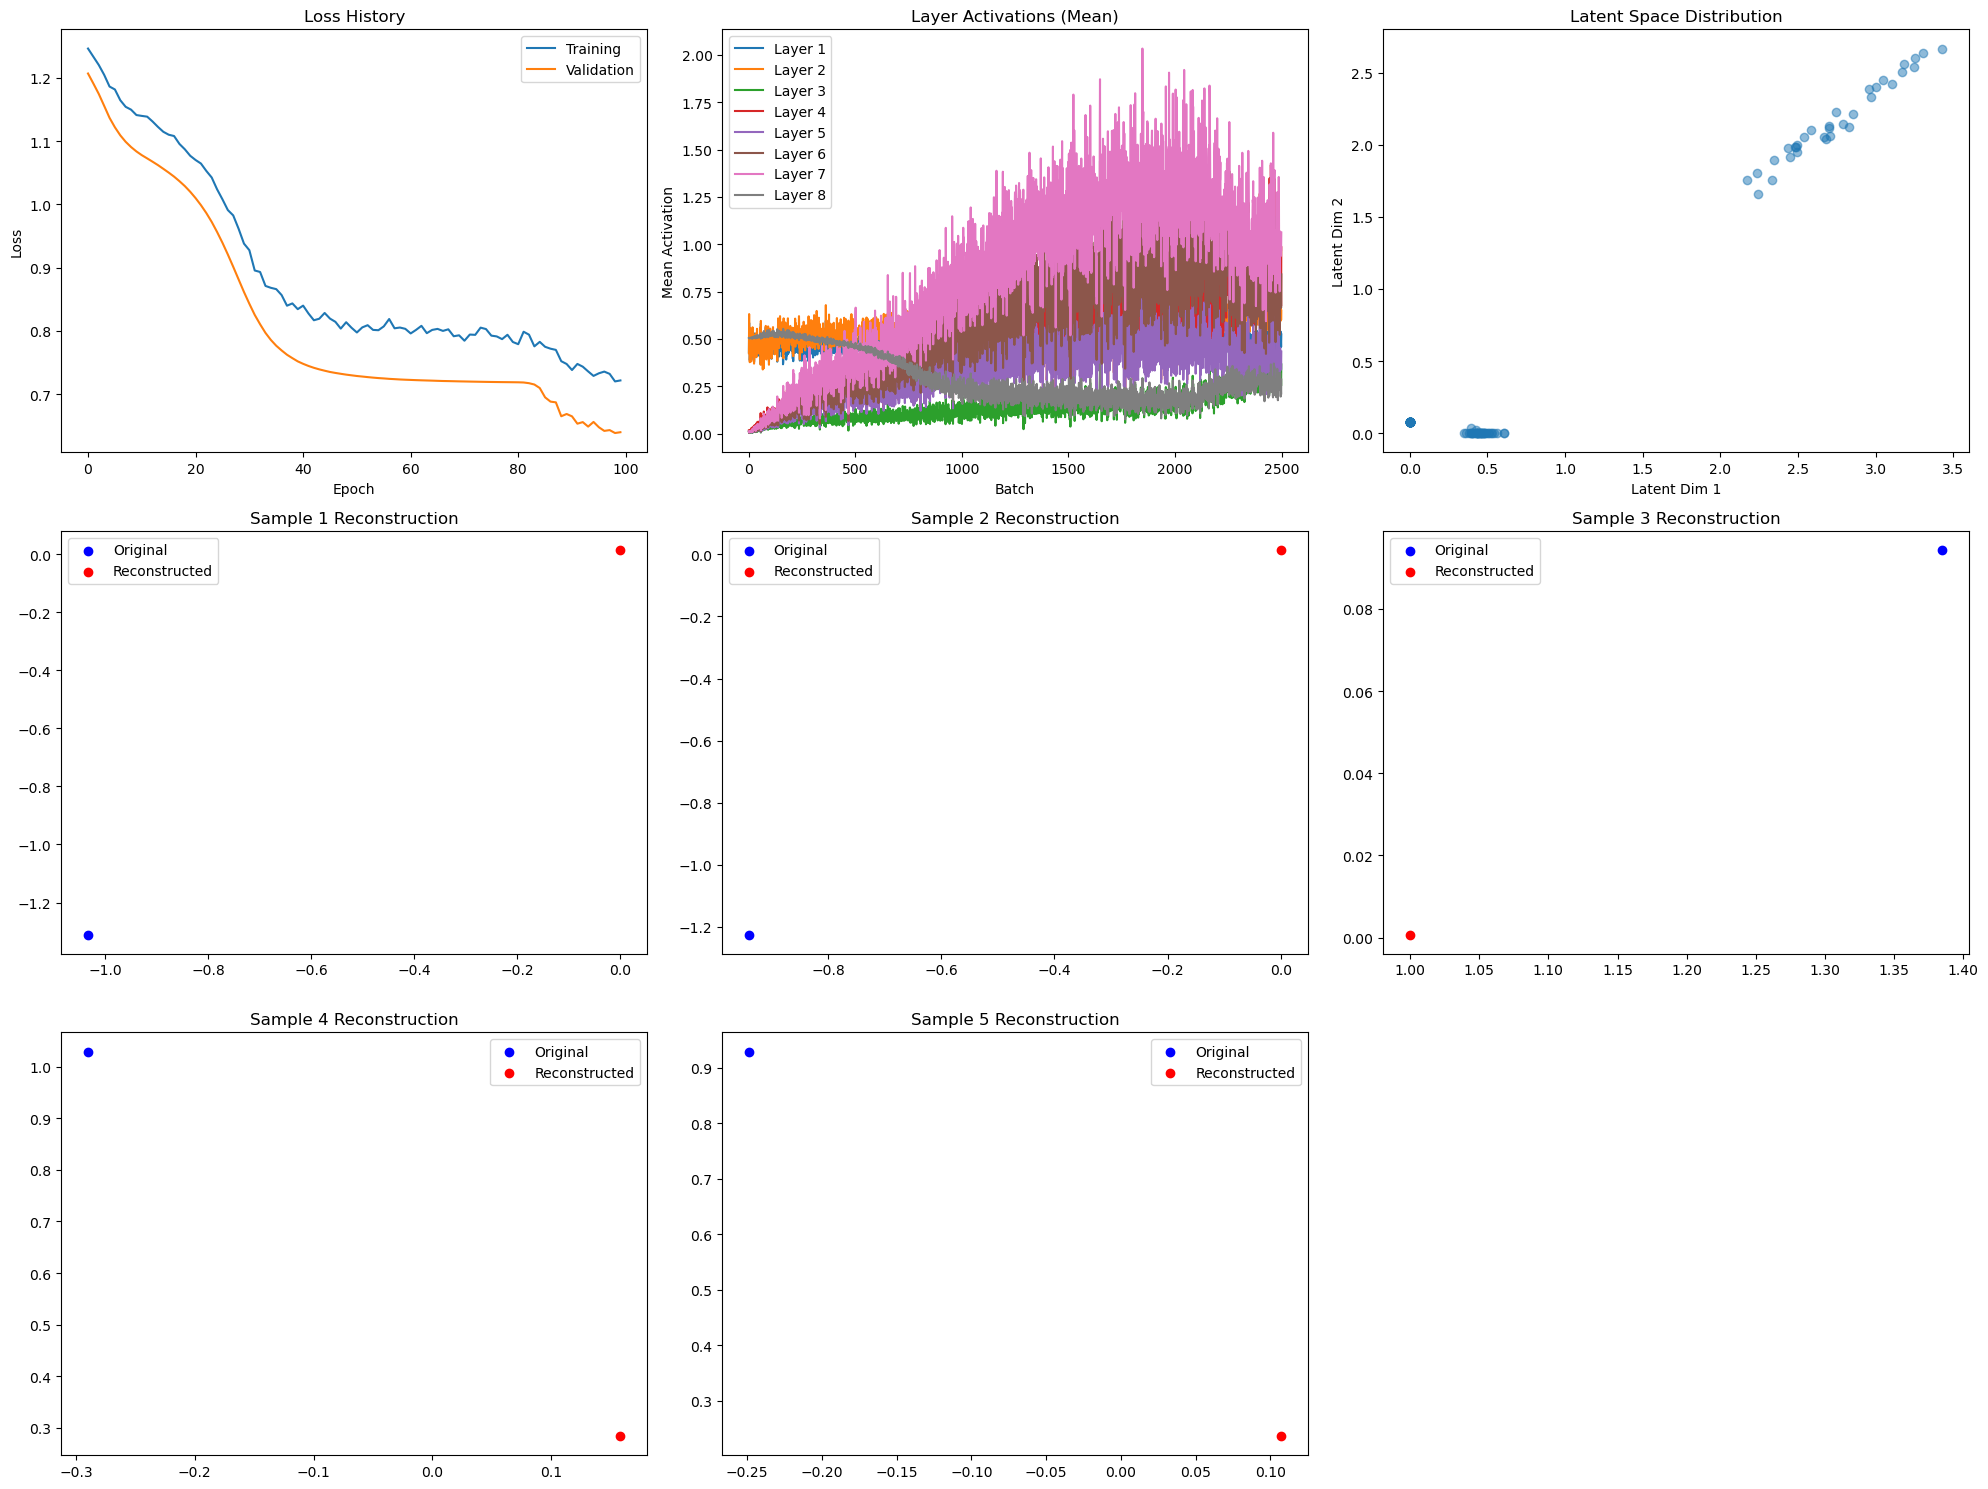

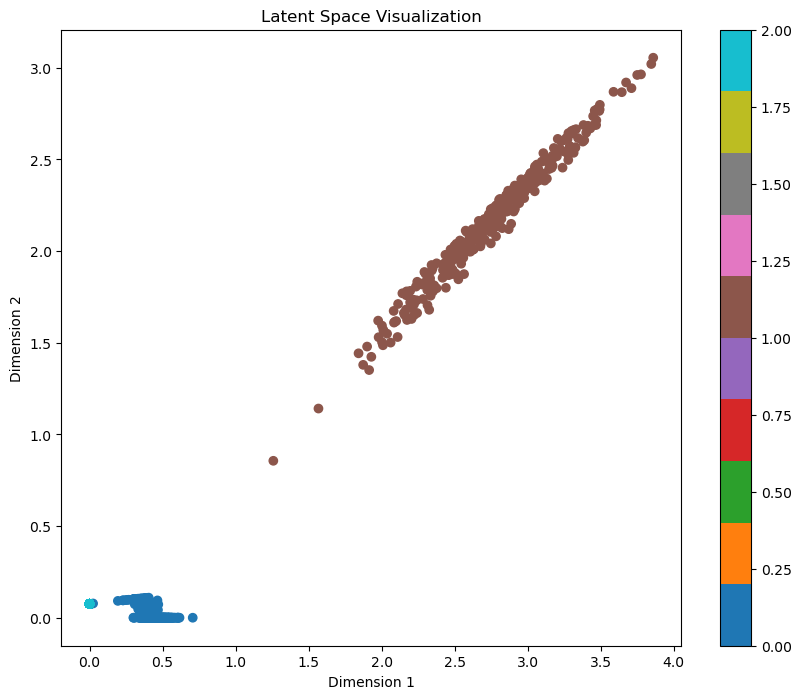

In [15]:
if __name__ == "__main__":
    n_samples = 1000
    n_clusters = 3
    input_dim = 2
    X, labels = make_blobs(n_samples=n_samples, centers=n_clusters, 
                          n_features=input_dim, random_state=42)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    train_size = int(0.8 * n_samples)
    X_train = X[:train_size]
    X_val = X[train_size:]
    
    autoencoder = Autoencoder(
        input_dim=input_dim,
        encoding_dim=2,
        hidden_dims=[8, 6, 4],
        activation='relu',
        output_activation='sigmoid',
        use_dropout=True,
        dropout_rate=0.05
    )
    
    autoencoder.example_input = X_train[:100]
    
    autoencoder.train(X_train, X_val, epochs=100, batch_size=32, 
                     learning_rate=0.001, loss_type='mse')
    
    autoencoder.plot_training_history()
    
    autoencoder.visualize_latent_space(X, labels)